In [1]:
import numpy as np
import pandas as pd
from astropy.table import Table
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from corr import lensingPCF

In [2]:
"""DR16 ELG"""

pathELG="/Users/rpaviot/eBOSSxDES/faizan/elg/eBOSS_ELG_SGC_pip_v7.dat.fits"

Tc = Table.read(pathELG)
Tc.remove_column('WEIGHT_BW')
Tc = Tc.to_pandas()
cond = ((Tc['CLUSTERING']==1) & (Tc['Z'] > 0.6) & (Tc['Z'] < 1.1))
Tc = Tc[cond]
ra_lens = Tc['RA'].values
dec_lens = Tc['DEC'].values
z_lens = Tc['Z'].values
w_lens = (Tc['WEIGHT_SYSTOT']*Tc['WEIGHT_FKP']*Tc['WEIGHT_NOZ']* Tc['WEIGHT_CP']).values

del Tc

"""DR16 random ELG"""

pathELGr="/Users/rpaviot/eBOSSxDES/faizan/elg/eBOSS_ELG_SGC_pip_v7.rnd.fits"
Tc = Table.read(pathELGr)
Tc = Tc.to_pandas()
Tc = Tc.reset_index()
cond = ((Tc['CLUSTERING']==1) & (Tc['Z'] > 0.6) & (Tc['Z'] < 1.1))
Tc = Tc[cond]


ra_r = Tc['RA'].values
dec_r = Tc['DEC'].values
z_r = Tc['Z'].values
w_r = (Tc['WEIGHT_SYSTOT']*Tc['WEIGHT_FKP']*Tc['WEIGHT_NOZ']* Tc['WEIGHT_CP']).values

size = len(Tc)
subsample = 0.5
arr = np.arange(0,size)
np.random.shuffle(arr)
indices = arr[0:int(subsample*size)]
ra_r = ra_r[indices]
dec_r = dec_r[indices]
z_r = z_r[indices]
w_r = w_r[indices]
del Tc

"""DES Y3 catalog"""

T = Table.read("/Volumes/LaCie/y3_eboss_overlap/desy3.fits")
T = T.to_pandas()

T = T[T.z_zmc > 0.6]
#z_zmc','z_mean','g1','g2','w'
ra_s = T['ra'].values
dec_s = T['dec'].values
z_s = T['z_zmc'].values
z_s2 = T['z_mean'].values
g1_s = T['g1'].values
g2_s = T['g2'].values
w_s = T['w'].values

"""Angular cuts"""

condang = ra_s > 180
ra_s[condang]=ra_s[condang]-360

bounds = np.array([ra_s.min(),ra_s.max(),dec_s.min(),dec_s.max()])

condang = ra_lens > 180
ra_lens = np.copy(ra_lens)
ra_lens[condang]=ra_lens[condang]-360

condang = ra_r > 180
ra_r = np.copy(ra_r)
ra_r[condang]=ra_r[condang]-360

condg = np.where((ra_lens > bounds[0]) & (ra_lens < bounds[1]) & (dec_lens > bounds[2]) & (dec_lens < bounds[3]))
condr =  np.where((ra_r > bounds[0]) & (ra_r < bounds[1]) & (dec_r > bounds[2]) & (dec_r < bounds[3]))

ra_r = ra_r[condr]
dec_r = dec_r[condr]
w_r = w_r[condr]
z_r = z_r[condr]

ra_lens  = ra_lens[condg]
dec_lens = dec_lens[condg]
z_lens = z_lens[condg]
w_lens = w_lens[condg]

bounds = np.array([ra_lens.min(),ra_lens.max(),dec_lens.min(),dec_lens.max()])
conds = np.where((ra_s > bounds[0]) & (ra_s < bounds[1]) & (dec_s > bounds[2]) & (dec_s < bounds[3]))
ra_s = ra_s[conds]
dec_s = dec_s[conds]
w_s = w_s[conds]
z_s = z_s[conds]
g1_s = g1_s[conds]
g2_s = g2_s[conds]

condang = ra_s < 0
ra_s[condang]=ra_s[condang]+360
condang = ra_r < 0
ra_r[condang]=ra_r[condang]+360
condang = ra_lens < 0
ra_lens[condang]=ra_lens[condang]+360


del T

In [3]:
"""Without redshift as input, must provide sep_units"""

corr = lensingPCF(Om0=0.3089,RA=ra_lens,DEC=dec_lens,W=w_lens,\
                  RA2=ra_s,DEC2=dec_s,W2=w_s,g1=g1_s,g2=g2_s,computation="GG",units="deg")
print(corr.units)
r,xi,xim,sigma = corr.gammat(1e-2,5,10,sep_units="degree")

deg
0 degree


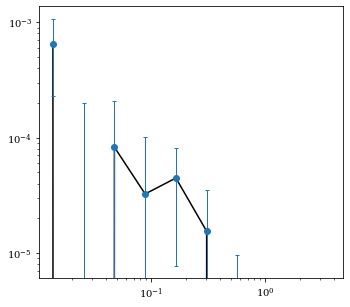

In [7]:
plt.rc('font',family='serif')
fig = plt.figure(figsize=(12,5))
gs = gridspec.GridSpec(1, 2)
gs.update(hspace=0 ,wspace=0.2)
ax = fig.add_subplot(gs[0])
ax.set_xscale('log')
ax.set_yscale('log')
plt.errorbar(r,xi,fmt="o",yerr=sigma,capthick=1,elinewidth=1,capsize=2,zorder=10)
plt.plot(r,xi,color="black")


In [8]:
"""With redshift as input"""

corr = lensingPCF(Om0=0.3089,RA=ra_lens,DEC=dec_lens,Z=z_lens,W=w_lens,\
                  RA2=ra_s,DEC2=dec_s,Z2=z_s,W2=w_s,g1=g1_s,g2=g2_s,computation="GG",units="degree")

"""Output unit always in unit of Mpc/h"""
r,xi,xim,sigma = corr.gammat(2e-1,30,10,min_rpar=10)

10 None


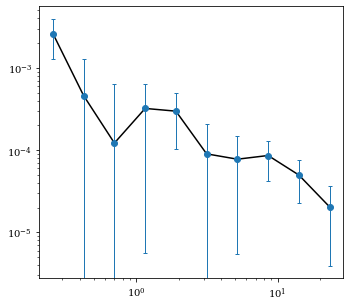

In [9]:
plt.rc('font',family='serif')
fig = plt.figure(figsize=(12,5))
gs = gridspec.GridSpec(1, 2)
gs.update(hspace=0 ,wspace=0.2)
ax = fig.add_subplot(gs[0])
ax.set_xscale('log')
ax.set_yscale('log')
plt.errorbar(r,xi,fmt="o",yerr=sigma,capthick=1,elinewidth=1,capsize=2,zorder=10)
plt.plot(r,xi,color="black")


In [10]:
"""With redshift as input and RS correlation"""

corr = lensingPCF(Om0=0.3089,RA=ra_lens,DEC=dec_lens,Z=z_lens,W=w_lens,\
                  RA2=ra_s,DEC2=dec_s,Z2=z_s,W2=w_s,g1=g1_s,g2=g2_s,computation="GG",units="degree")

corr.set_random(RA_r = ra_r,DEC_r=dec_r,Z_r=z_r,W_r=w_r)

"""Output unit always in unit of Mpc/h"""
r,xi,xim,sigma = corr.gammat(2e-1,30,10,min_rpar=10)

10 None


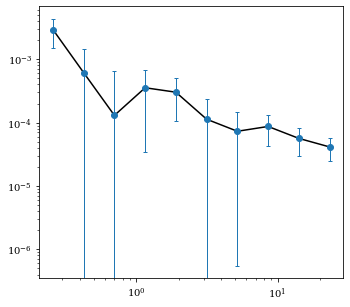

In [12]:
plt.rc('font',family='serif')
fig = plt.figure(figsize=(12,5))
gs = gridspec.GridSpec(1, 2)
gs.update(hspace=0 ,wspace=0.2)
ax = fig.add_subplot(gs[0])
ax.set_xscale('log')
ax.set_yscale('log')
plt.errorbar(r,xi,fmt="o",yerr=sigma,capthick=1,elinewidth=1,capsize=2,zorder=10)
plt.plot(r,xi,color="black")